In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.io import imread

import nibabel as nib

/Users/woo/.pyenv/versions/3.7.4/envs/brain_seg/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
train_dir = "./Dataset/Training/Data"

file_list = os.listdir("./Dataset/Training/Data")
nii_files = [os.path.join(train_dir, file) for file in file_list if file.endswith(".nii")]
glm_files = [file for file in nii_files if file.endswith("glm.nii")]
for glm in glm_files:
    nii_files.remove(glm)

In [4]:
nib.Nifti1Header.quaternion_threshold = -1e-06  # https://github.com/nipy/nibabel/issues/626
img = np.array(nib.load(nii_files[0]).dataobj).astype(np.float64)

### padding
img = np.pad(img, ((14,14),(14,14),(14,14)),'constant', constant_values=(0))

print(img.shape)

i,j,k =100,100,100
# center (14,14)
print(img[i-14:i+15, j-14:j+15, k].shape)
print(img[i, j-14:j+15, k-14:k+15].shape)
print(img[i-14:i+15, j, k-14:k+15].shape)

(284, 284, 347)
(29, 29)
(29, 29)
(29, 29)


In [5]:
data_dir = "./Dataset/Training/Data"
# data_file = "1000_3.nii"
data_file = None

if data_file is None and data_dir:
    file_list = os.listdir(data_dir)
    nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii")]
    glm_files = [file for file in nii_files if file.endswith("glm.nii")]
    for glm in glm_files:
        nii_files.remove(glm)

elif isinstance(data_file, str):
    nii_files = [os.path.join(data_dir, data_file)]
    glm_files = [nii_files[0].split(".n")[0] + "_glm.nii"]


### settings for nibabel ###
nib.Nifti1Header.quaternion_threshold = -1e-06
data_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in nii_files]

len(data_list)

15

# GET X, Y data

In [6]:
data_dir = "./Dataset/Training/Data"
# data_file = "1000_3.nii"
data_file = None

if data_file is None and data_dir:
    file_list = os.listdir(data_dir)
    nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii") and not file.endswith("glm.nii")]
    glm_files = []
    for nii in nii_files:
        directory, file = os.path.split(nii)
        glm_files.append(os.path.join(directory, file.split(".")[0]+"_glm.nii"))

elif isinstance(data_file, str):
    nii_files = [os.path.join(data_dir, data_file)]
    glm_files = [nii_files[0].split(".n")[0] + "_glm.nii"]


### settings for nibabel ###
nib.Nifti1Header.quaternion_threshold = -1e-06

print(nii_files)
print(glm_files)

data_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in nii_files]
label_list = [np.array(nib.load(data).dataobj).astype(np.float64) for data in glm_files]

print(len(data_list))

['./Dataset/Training/Data/1015_3.nii', './Dataset/Training/Data/1017_3.nii', './Dataset/Training/Data/1013_3.nii', './Dataset/Training/Data/1011_3.nii', './Dataset/Training/Data/1008_3.nii', './Dataset/Training/Data/1014_3.nii', './Dataset/Training/Data/1010_3.nii', './Dataset/Training/Data/1009_3.nii', './Dataset/Training/Data/1036_3.nii', './Dataset/Training/Data/1012_3.nii', './Dataset/Training/Data/1007_3.nii', './Dataset/Training/Data/1001_3.nii', './Dataset/Training/Data/1006_3.nii', './Dataset/Training/Data/1002_3.nii', './Dataset/Training/Data/1000_3.nii']
['./Dataset/Training/Data/1015_3_glm.nii', './Dataset/Training/Data/1017_3_glm.nii', './Dataset/Training/Data/1013_3_glm.nii', './Dataset/Training/Data/1011_3_glm.nii', './Dataset/Training/Data/1008_3_glm.nii', './Dataset/Training/Data/1014_3_glm.nii', './Dataset/Training/Data/1010_3_glm.nii', './Dataset/Training/Data/1009_3_glm.nii', './Dataset/Training/Data/1036_3_glm.nii', './Dataset/Training/Data/1012_3_glm.nii', './Datas

In [7]:
print(data_list[0].shape)
print(label_list[0].shape)

(256, 256, 319)
(256, 256, 319)


In [8]:
def return_largest_size(data_list):
    x_size, y_size, z_size = 0, 0, 0
    for data in data_list:
        n_x_size, n_y_size, n_z_size = data.shape
        if n_x_size > x_size: x_size = n_x_size
        if n_y_size > y_size: y_size = n_y_size
        if n_z_size > z_size: z_size = n_z_size
    return (x_size, y_size, z_size)

largest_size = return_largest_size(data_list)

print(largest_size)

(256, 256, 334)


In [5]:
def add_zero_padding_with_shape(arr, shp):
    x_s, y_s, z_s = arr.shape
    new_array = np.zeros(shape=shp)
    new_array[:x_s, :y_s, :z_s] = arr
    return new_array

In [6]:
add_zero_padding_with_shape(data_list[0], largest_size).sum()
add_zero_padding_with_shape(data_list[0], largest_size).shape

(256, 256, 334)

In [50]:
padding=43
x_s,y_s,z_s = largest_size
data = np.zeros(shape=(len(data_list), x_s+(padding*2), y_s+(padding*2), z_s+(padding*2)))
for idx, single_data in enumerate(data_list):
    data[idx] = np.pad(add_zero_padding_with_shape(single_data, largest_size), ((padding,padding),(padding,padding),(padding,padding)),'constant', constant_values=(0))

In [51]:
data[0].max()

4077.0

In [53]:
data[1].max()

3968.0

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
scaler = MinMaxScaler()
for i in range(data[0].shape[0]):
    scaler.partial_fit(data[0][i])

In [60]:
for num_of_data in range(data.shape[0]):
    scaler = MinMaxScaler()
    for i in range(data[num_of_data].shape[0]):
        scaler.partial_fit(data[num_of_data][i])
    for j in range(data[num_of_data].shape[0]):
        data[num_of_data][j]=scaler.transform(data[num_of_data][j])

In [61]:
data[0].max()

1.0

# CENTROID

In [7]:
class RegionCentroids():
    def __init__(self, n_regions):
        self.n_regions = n_regions
        self.barycentres = np.zeros((n_regions, 3))

    def update_barycentres(self, vxs, regions):
        self.barycentres = np.zeros((self.n_regions, 3))
        for i in range(self.n_regions):
            idxs = regions == i
            if vxs[idxs].size == 0:
                continue
            self.barycentres[i] = (np.mean(vxs[idxs], axis=0))

        # For zero values (with no regions present), set them to the mean
        self.barycentres[self.barycentres == 0] = self.barycentres[self.barycentres != 0].mean()

    def compute_scaled_distances(self, vx):
        distances = np.linalg.norm(self.barycentres - vx, axis=1)
        return distances

In [10]:
x = data_list[0]
y = label_list[0]

region_centroids = RegionCentroids(208) # parameter로 전체 label + 1개 전달
temp = y.nonzero()
print(temp)
vxs = np.asarray(temp).T
region_centroids.update_barycentres(vxs, y[temp])

NameError: name 'data_list' is not defined

# GET DATA FOR SINGLE BRAIN

In [11]:
x = data_list[0]
y = label_list[0]


# get centroid object

def get_centroid_obj(y):
    label_list = np.unique(y)
    centroid_obj = RegionCentroids(int(label_list.max())+1) # parameter로 전체 label + 1개 전달
    temp = y.nonzero()
    vxs = np.asarray(temp).T
    centroid_obj.update_barycentres(vxs, y[temp])
    return centroid_obj

# get patches
def get_patches(x, y):
    patches = []
    x_shape = x.shape
    for i in range(x_shape[0]):
        for j in range(x_shape[1]):
            for k in range(x_shape[2]):
                if y[i][j][k] == 0:
                    pass
                else:
                    patches.append(
                        {
                            "y_index" : [i,j,k],
                            "y_value" : y[i][j][k],
                            "3d_patch_scale_1" : x[i-14:i+15, j-14:j+15, k-14:k+15],
                            "3d_patch_scale_3" : x[i-43:i+44, j-43:j+44, k-43:k+44],
                        }
                    )
    return patches

single_brain_data = {
    "x" : x,
    "y" : y,
    "patch" : get_patches(x, y),
    "centroid" : get_centroid_obj(y),
}
                
# patch_x_scale_1 => 3d_patch_scale_1[14]
# patch_y_scale_1 => 3d_patch_scale_1[:, 14]
# patch_z_scale_1 => 3d_patch_scale_1[:,:,14]

# patch_x_scale_3 => 3d_patch_scale_3[43]
# patch_y_scale_3 => 3d_patch_scale_3[:, 43]
# patch_z_scale_3 => 3d_patch_scale_3[:, :, 43]

# DATA LOADER on USE

In [36]:
import time

from loader.dataloader import get_data, get_valid_voxel
from loader.dataloader import BrainSegmentationDataset, BrainSegmentationDataset3D
from loader.utils import return_label_dicts

present_label_list =  [  0,   4,  11,  15,  23,  30,  31,  32,  35,  36,  37,
                        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
                        49,  50,  51,  52,  55,  56,  57,  58,  59,  60,  61,
                        62,  63,  64,  65,  66,  69,  71,  72,  73,  74,  75,
                        76, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                        123, 124, 125, 128, 129, 132, 133, 134, 135, 136, 137,
                        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
                        149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161,
                        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
                        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
                        184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196,
                        197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207] # len(present_label_list) = 143 | all labels on train set


def return_label_dicts(present_label_list):
    label_to_idx, idx_to_label = {}, {}
    for idx, l in enumerate(present_label_list):
        label_to_idx[l] = idx
        idx_to_label[idx] = l
    return label_to_idx, idx_to_label

label_to_idx, idx_to_label = return_label_dicts(present_label_list)


def get_valid_voxel(x, y, label_to_idx):
    valid_voxel = []
    x_shape = x.shape
    for i in range(x_shape[0]):
        for j in range(x_shape[1]):
            for k in range(x_shape[2]):
                for l in range(x_shape[3]):
                    if x[i][j][k][l] == 0:
                        pass
                    else:
                        valid_voxel.append(
                            {
                                "y_index" : [i,j,k,l],
                                "y_value" : label_to_idx[int(y[i][j][k][l])],
                            }
                        )
    return valid_voxel


def get_valid_voxel_y(x, y, label_to_idx):
    valid_voxel = []
    x_shape = x.shape
    for i in range(x_shape[0]):
        for j in range(x_shape[1]):
            for k in range(x_shape[2]):
                for l in range(x_shape[3]):
                    if y[i][j][k][l] == 0:
                        pass
                    else:
                        valid_voxel.append(
                            {
                                "y_index" : [i,j,k,l],
                                "y_value" : label_to_idx[int(y[i][j][k][l])],
                            }
                        )
    return valid_voxel

def get_valid_voxel_nonzero(x, y, label_to_idx):
    valid_voxel = []
    a_1, a_2, a_3, a_4 = x.nonzero()
    
    for i in range(len(a_1)): 
        if y[a_1[i]][a_2[i]][a_3[i]][a_4[i]] == 0:
            pass
        else:
            valid_voxel.append(
                {
                    "y_index" : [a_1[i],a_2[i],a_3[i],a_4[i]],
                    "y_value" : label_to_idx[int(y[a_1[i]][a_2[i]][a_3[i]][a_4[i]])],
                }
            )
    
    return valid_voxel

print("GET DATA")
data_dir = "./Dataset/Training/Data"
data_file = None

test_dir = "./Dataset/Testing/Data"
test_file = None

data, label, test_data, test_label = get_data(data_dir, data_file=data_file, num_of_data=1, padding=43, get_test_set=True)

print(data.shape)


a = time.time()
single_brain_data_with_y = {
    "x" : data,
    "y" : label,
    "patch" : get_valid_voxel_y(data, label, label_to_idx)
}

b = time.time()

single_brain_data_with = {
    "x" : data,
    "y" : label,
    "patch" : get_valid_voxel_y(data, label, label_to_idx)
}

c = time.time()

single_brain_data_with_nonzero = {
    "x" : data,
    "y" : label,
    "patch" : get_valid_voxel_nonzero(data, label, label_to_idx)
}

d = time.time()

print(b-a)
print(c-b)
print(d-c)


GET DATA
(1, 342, 342, 405)
38.5578670501709
36.237714767456055
9.890531301498413


In [11]:
print(len(single_brain_data_with["patch"]))
print(len(single_brain_data_with_y["patch"]))
print(len(single_brain_data_with_nonzero["patch"]))

1290611
1290611
1290611


In [14]:
import numpy as np

class RegionCentroids():
    def __init__(self, n_regions):
        self.n_regions = n_regions
        self.barycentres = np.zeros((n_regions, 3))

    def update_barycentres(self, vxs, regions):
        self.barycentres = np.zeros((self.n_regions, 3))
        for i in range(self.n_regions):
            idxs = regions == i
            if vxs[idxs].size == 0:
                continue
            self.barycentres[i] = (np.mean(vxs[idxs], axis=0))

        # For zero values (with no regions present), set them to the mean
        self.barycentres[self.barycentres == 0] = self.barycentres[self.barycentres != 0].mean()

    def compute_scaled_distances(self, vx):
        distances = np.linalg.norm(self.barycentres - vx, axis=1)
        return distances
    
x = data[0]
y = label[0]

region_centroids = RegionCentroids(208) # parameter로 전체 label + 1개 전달
temp = y.nonzero()
print(temp)
vxs = np.asarray(temp).T
region_centroids.update_barycentres(vxs, y[temp])

(array([ 93,  93,  93, ..., 223, 223, 223]), array([169, 169, 169, ..., 167, 167, 167]), array([168, 169, 170, ..., 160, 162, 164]))


In [17]:
region_centroids.barycentres[6]

array([169.43726317, 169.43726317, 169.43726317])

In [57]:
a = region_centroids.compute_scaled_distances([1,2,9])
ma = a.max()
a = a / ma
print(a)

[0.82084432 0.82084432 0.82084432 0.82084432 0.84781646 0.82084432
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.84574334
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.87149045
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432
 0.89380839 0.84774924 0.90418521 0.82084432 0.82084432 0.86287285
 0.8354806  0.8697608  0.8032421  0.87204107 0.81910717 0.86893237
 0.72987564 0.82401998 0.7600327  0.84100379 0.80048077 0.80347099
 0.8725357  0.78630903 0.87404408 0.77785848 0.82048635 0.82084432
 0.82084432 0.8229937  0.87570784 0.8213542  0.88899768 0.79918306
 0.83060449 0.83136009 0.85744974 0.82306751 0.90212493 0.87925785
 0.82084432 0.82084432 0.82084432 0.88421544 0.82084432 0.79537437
 0.80214619 0.83884793 0.82084432 0.90078506 0.86111308 0.82084432
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432
 0.82084432 0.82084432 0.82084432 0.82084432 0.82084432 0.8208

In [38]:
original_label = label

In [39]:
f = label.flatten()

In [40]:
label.shape

(1, 342, 342, 405)

In [49]:
f = f.reshape(label.shape)
f.max()

207.0

In [46]:
def return_new_label(l, label_to_idx):
    return label_to_idx[l]
    
vectorized_return_new_label = np.vectorize(return_new_label, otypes=[np.int])

n = vectorized_return_new_label(f, label_to_idx)

In [51]:
def return_new_label(l, label_to_idx):
    return label_to_idx[l]

def get_valid_label(original_label, label_to_idx):
    vectorized_return_new_label = np.vectorize(return_new_label, otypes=[np.int])

    return vectorized_return_new_label(original_label, label_to_idx)

In [59]:
get_valid_label(label, label_to_idx).max()

142

In [64]:
label[0,2,3,4]

0.0

## PICKLE SAVE

In [ ]:
# import pickle

# with open('1015_3.pickle', 'wb') as f:
#     pickle.dump(single_brain_data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('1015_3.pickle', 'rb') as f:
#     data = pickle.load(f)
    
# print(data.keys())

In [10]:
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14][14][14])
print(single_brain_data["patch"][0]["3d_patch_scale_1"].shape)

574.0
(29, 29, 29)


## Patch images

574.0
574.0


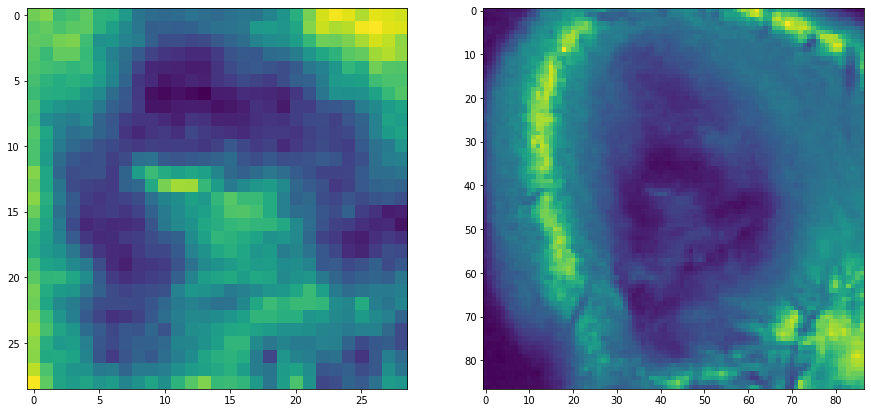

In [42]:
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14,14,14])
print(single_brain_data["patch"][0]["3d_patch_scale_3"][43,43,43])

f, axarr = plt.subplots(1,2, figsize=(15,15)) 
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][43])

574.0
574.0
(29, 29)
(29, 29)
841


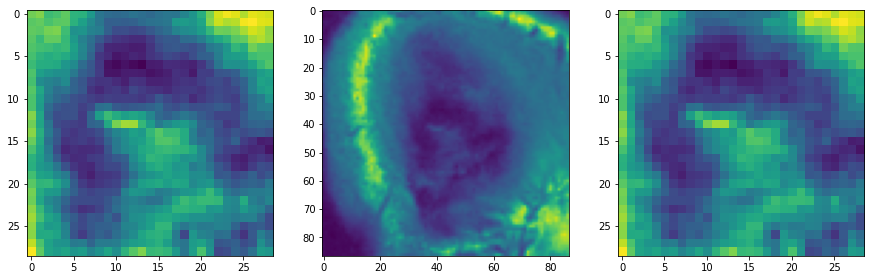

In [45]:
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14][14][14])
print(single_brain_data["patch"][0]["3d_patch_scale_3"][43][43][43])

f, axarr = plt.subplots(1,3, figsize=(15,15)) 
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][43])
axarr[2].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][43,29:58, 29:58])


print(single_brain_data["patch"][0]["3d_patch_scale_3"][43, 29:58, 29:58].shape)
print(single_brain_data["patch"][0]["3d_patch_scale_1"][14].shape)
print((single_brain_data["patch"][0]["3d_patch_scale_3"][43, 29:58, 29:58] == single_brain_data["patch"][0]["3d_patch_scale_1"][14]).sum())

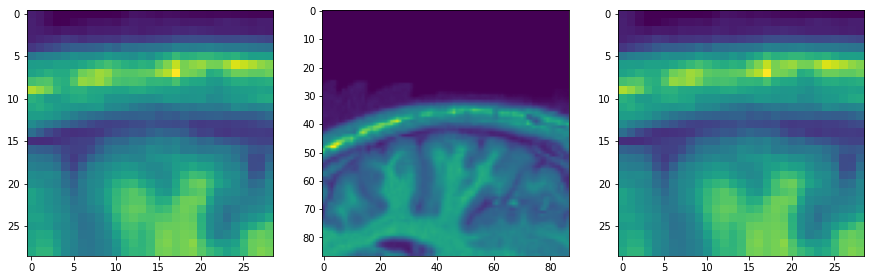

In [39]:
f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][:, 14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, 43])
axarr[2].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, 43][29:58, 29:58])

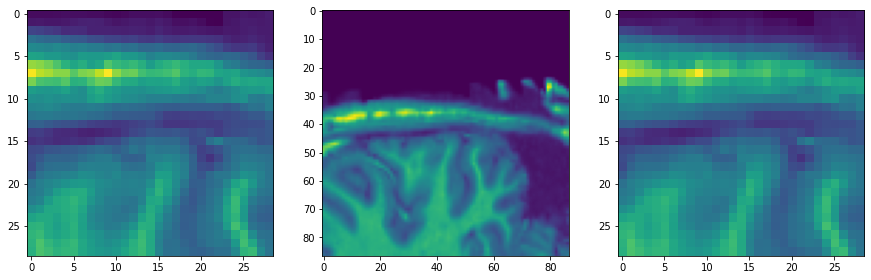

In [40]:
f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(single_brain_data["patch"][0]["3d_patch_scale_1"][:, :, 14])
axarr[1].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, :, 43])
axarr[2].imshow(single_brain_data["patch"][0]["3d_patch_scale_3"][:, :, 43][29:58, 29:58])

## Centroids

In [14]:
single_brain_data["centroid"].n_regions

208

In [15]:
# single_brain_data["centroid"].barycentres
# single_brain_data["centroid"].compute_scaled_distances([130,120,120])

# TORCH DATALOADER

In [48]:
class BrainSegmentationDataset(Dataset):

    def __init__(self,single_brain_data):
        self.single_brain_data = single_brain_data
        self.patch = single_brain_data["patch"]
        self.centroid = single_brain_data["centroid"]
        print("patch length", len(self.patch))

    def __len__(self):
        return len(self.single_brain_data)

    def __getitem__(self, idx):
        x = {}
        sample = self.patch[idx]
        patch_scale_1 = sample["3d_patch_scale_1"]
        x["patch_x_scale_1"] = torch.unsqueeze(torch.Tensor(patch_scale_1[14]), 0)
        x["patch_y_scale_1"] = torch.unsqueeze(torch.Tensor(patch_scale_1[:, 14]), 0)
        x["patch_z_scale_1"] = torch.unsqueeze(torch.Tensor(patch_scale_1[:, : ,14]), 0)
        
        patch_scale_3 = sample["3d_patch_scale_3"]
        x["patch_x_scale_3"] = torch.Tensor(patch_scale_3[43])
        x["patch_y_scale_3"] = torch.Tensor(patch_scale_3[:, 43])
        x["patch_z_scale_3"] = torch.Tensor(patch_scale_3[:, :, 43])
        
        x["centroid"] = self.centroid.compute_scaled_distances(sample["y_index"])
        
        y = sample["y_value"]
        
        return (x, y)

# Test dataloader

In [62]:
brain_dataset = BrainSegmentationDataset(single_brain_data)

brain_dataloader = DataLoader(brain_dataset, batch_size=4)

patch length 1290611


In [63]:
print(len(brain_dataset.patch))

count = 0
for i, j in brain_dataloader:
    print("x", x["patch_x_scale_1"].shape)
    count += 1
    if count == 10:
        break


1290611
x torch.Size([29, 29])


In [19]:
from model.brain_segmentation_model import CNN_module

In [20]:
a = CNN_module()

In [25]:
single_brain_data.keys()

dict_keys(['x', 'y', 'patch', 'centroid'])

In [1]:
len(single_brain_data["patch"])

NameError: name 'single_brain_data' is not defined

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.io import imread

import nibabel as nib

def return_largest_size(data_list):
    x_size, y_size, z_size = 0, 0, 0
    for data in data_list:
        n_x_size, n_y_size, n_z_size = data.shape
        if n_x_size > x_size: x_size = n_x_size
        if n_y_size > y_size: y_size = n_y_size
        if n_z_size > z_size: z_size = n_z_size
    return (x_size, y_size, z_size)


def add_zero_padding_with_shape(arr, shp):
    array_shp = arr.shape
    new_array = np.zeros(shape=shp)
    new_array[:array_shp[0], :array_shp[1], :array_shp[2]] = arr
    return new_array


def get_data(data_dir, data_file=None, num_of_data=None, padding=0):

    """
    data_file -> None : get all data from data directory
    """

    if data_file is None and data_dir:
        file_list = os.listdir(data_dir)
        nii_files = [os.path.join(data_dir, file) for file in file_list if file.endswith(".nii") and not file.endswith("glm.nii")]
        glm_files = []
        for nii in nii_files:
            directory, file = os.path.split(nii)
            glm_files.append(os.path.join(directory, file.split(".")[0]+"_glm.nii"))

    elif isinstance(data_file, str):
        nii_files = [os.path.join(data_dir, data_file)]
        glm_files = [nii_files[0].split(".n")[0] + "_glm.nii"]


    ### settings for nibabel ###
    nib.Nifti1Header.quaternion_threshold = -1e-06

    ### MAKE DATA AS SINGLE NDARRAY ###

    data_list = [np.array(nib.load(data).dataobj).astype(np.float32) for data in nii_files]
    label_list = [np.array(nib.load(data).dataobj).astype(np.float32) for data in glm_files]

    if isinstance(num_of_data, int):
        data_list = data_list[:num_of_data + 1]
        label_list = label_list[:num_of_data + 1]

    x_s,y_s,z_s = return_largest_size(data_list)

    data = np.zeros(shape=(len(data_list), x_s+(padding*2), y_s+(padding*2), z_s+(padding*2)))
    label = np.zeros(shape=(len(data_list), x_s+(padding*2), y_s+(padding*2), z_s+(padding*2)))

    for idx, single_data in enumerate(data_list):
        data[idx] = np.pad(add_zero_padding_with_shape(single_data, (x_s,y_s,z_s)), ((padding,padding),(padding,padding),(padding,padding)),'constant', constant_values=(0))
    for idx, single_data in enumerate(label_list):
        label[idx] = np.pad(add_zero_padding_with_shape(single_data, (x_s,y_s,z_s)), ((padding,padding),(padding,padding),(padding,padding)),'constant', constant_values=(0))

    ### PREPROCESSING ###

    # MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    for num_of_data in range(data.shape[0]):
        scaler = MinMaxScaler()
#         standard_scaler = StandardScaler()
        for i in range(data[num_of_data].shape[0]):
            scaler.partial_fit(data[num_of_data][i])
        for j in range(data[num_of_data].shape[0]):
            data[num_of_data][j]=scaler.transform(data[num_of_data][j])

    train_set, train_label = data[:-1], label[:-1]
    test_set, test_label = np.array([data[-1]]), np.array([label[-1]])

    return train_set, train_label, test_set, test_label


def get_valid_label(x, y):
    valid_label = []
    x_shape = x.shape
    for i in range(x_shape[0]):
        for j in range(x_shape[1]):
            for k in range(x_shape[2]):
                for l in range(x_shape[2]):
                    if y[i][j][k][l] == 0:
                        pass
                    else:
                        valid_label.append(
                            {
                                "y_index" : [i,j,k,l],
                                "y_value" : int(y[i][j][k][l]),
                            }
                        )
    return valid_label

### TORCH DATALOADER


class BrainSegmentationDataset(Dataset):

    def __init__(self,single_brain_data, valid_label):
        self.single_brain_data = single_brain_data
        self.valid_label = valid_label
        print("NUM OF PATCHS : {}".format(len(valid_label)))

    def __len__(self):
        return len(self.valid_label)   # 이거 중요함... 이거 잘못 넣으면 출력되는 데이터 개수가 이상하게 나옴.

    def __getitem__(self, idx):
        x = {}
        data_index = self.valid_label[idx]["y_index"]
        i, j, k, l = data_index[0], data_index[1], data_index[2], data_index[3]

        sample = self.single_brain_data[i][j-43:j+44, k-43:k+44, l-43:l+44]
        x["patch_x_scale_1"] = torch.unsqueeze(torch.from_numpy(sample[43][29:58, 29:58]), 0)
        x["patch_y_scale_1"] = torch.unsqueeze(torch.from_numpy(sample[:, 43][29:58, 29:58]), 0)
        x["patch_z_scale_1"] = torch.unsqueeze(torch.from_numpy(sample[:, : ,43][29:58, 29:58]), 0)

        x["patch_x_scale_3"] = torch.unsqueeze(torch.from_numpy(sample[43]), 0)
        x["patch_y_scale_3"] = torch.unsqueeze(torch.from_numpy(sample[:, 43]), 0)
        x["patch_z_scale_3"] = torch.unsqueeze(torch.from_numpy(sample[:, :, 43]), 0)
        
        # x["centroid"] = self.centroid.compute_scaled_distances(sample["y_index"])
        
        y = self.valid_label[idx]["y_value"]
        
        return (x, y)

/Users/woo/.pyenv/versions/3.7.4/envs/brain_seg/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
print("GET DATA")
data_dir = "./Dataset/Training/Data"
data_file = None

data, label, test_data, test_label = get_data(data_dir, data_file=data_file, num_of_data=3, padding=43)

GET DATA


## with STANDARD

In [ ]:
data[0][232:240, 222, 222]

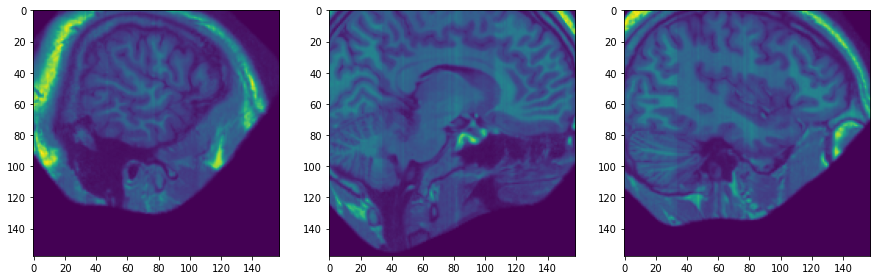

In [37]:
f, axarr = plt.subplots(1,3, figsize=(15,15)) 
axarr[0].imshow(data[1][100, 100:258, 100:258])
axarr[1].imshow(data[1][150, 100:258, 100:258])
axarr[2].imshow(data[1][200, 100:258, 100:258])

## with MINMAX

In [32]:
data[0][232:240, 222, 222]

array([0.00111545, 0.00027886, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

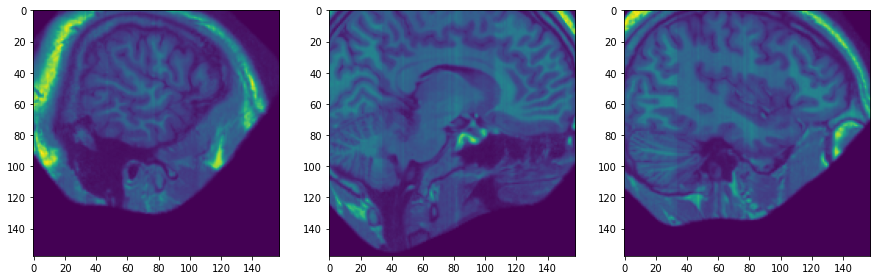

In [36]:
f, axarr = plt.subplots(1,3, figsize=(15,15)) 
axarr[0].imshow(data[1][100, 100:258, 100:258])
axarr[1].imshow(data[1][150, 100:258, 100:258])
axarr[2].imshow(data[1][200, 100:258, 100:258])

# LABEL PROBLEM

In [48]:
data, label, test_data, test_label = get_data(data_dir, data_file=data_file, num_of_data=None, padding=43)

In [50]:
uq = np.unique(label)

In [51]:
len(uq)

143

In [75]:
data.shape

(14, 342, 342, 420)

In [78]:
test_label.shape

(1, 342, 342, 420)

In [3]:
# GET TRAINSET
valid_label = get_valid_label(data, label)
brain_dataset = BrainSegmentationDataset(data, valid_label)
brain_dataloader = DataLoader(brain_dataset, batch_size=512, shuffle=True)

# GET TESTSET
test_valid_label = get_valid_label(test_data, test_label)
test_brain_dataset = BrainSegmentationDataset(test_data, test_valid_label)
test_brain_dataloader = DataLoader(test_brain_dataset, batch_size=512, shuffle=True)

NUM OF PATCHS : 3921017
NUM OF PATCHS : 1358843


In [6]:
# print(data.shape)
# print(label.shape)
# print(test_data.shape)
# print(test_label.shape)
# test_valid_label = get_valid_label(test_data, test_label)
from tqdm import tqdm

for x, y in tqdm(brain_dataloader, desc="epoch 1"):
    a = 0

epoch 1:  25%|██▌       | 1946/7659 [04:27<13:06,  7.26it/s]  


KeyboardInterrupt: 

In [7]:
# data_index = test_valid_label[-2]["y_index"]
# i, j, k, l = data_index[0], data_index[1], data_index[2], data_index[3]
# print(i,j,k,l)

{'y_index': [0, 205, 181, 166], 'y_value': 155}

In [9]:
print(len(test_valid_label))
for idx in range(len(test_valid_label)):
    data_index = test_valid_label[idx]["y_index"]
    i, j, k, l = data_index[0], data_index[1], data_index[2], data_index[3]
    if i != 0:
        print(i)

1358843


In [18]:
count = 0
for test_data, test_labels in test_brain_dataloader:
    count += 1

In [ ]:
### SETTINGS FOR TRAINING ###

print("SETTINGS FOR TRAINING")
from model.segnet import SegNet

learning_rate = 0.01
epochs = 9

model = SegNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()


### TRAINING ###

print("TRAINING START")

step = 0
loss_list, acc_list = [], []
for epoch in range(epochs):
    # train
    print('epoch : {}'.format(epoch+1))
    for x, y in brain_dataloader:
        step += 1
        output = model(x)
        loss = loss_func(output, y)
        print("y")
        print(y.shape)
        print("output")
        print(output.shape)
        print(output)
        print("loss")
        print(loss)
        break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validation
    if epoch % 3 == 0:
        model.eval()
        count = 0
        accuracy = 0
        for test_data, test_labels in brain_dataloader:
            count += 1
            test_output = model(test_data)
            pred = torch.max(test_output, 1)[1].data.numpy()
            accuracy += float((pred == test_labels.data.numpy()).astype(int).sum()) / float(test_labels.size(0))
            # print("EVALUATION) Epoch : {} | step : {} | loss : {} | accuracy : {}".format(epoch, step, round(float(loss.data),4), accuracy))
        print("EVALUATION) Epoch : {} | step : {} | accuracy : {}".format(epoch+1, step,  round( accuracy/count, 4)))
            # loss_list.append(round(float(loss.data), 2))
        acc_list.append(round(float(accuracy) / count, 2))
        model.train()

print(acc_list)

In [8]:
uq = np.unique(label.reshape(-1))

In [9]:
len(uq)

140

In [10]:
uq

array([  0.,   4.,  11.,  23.,  30.,  31.,  32.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  69.,  71.,  72.,  73.,  75.,  76., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       128., 129., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 190., 191., 192., 193., 194., 195., 196., 197., 198., 199.,
       200., 201., 202., 203., 204., 205., 206., 207.])

In [11]:
data, label = get_data(data_dir, data_file=data_file, padding=43)

In [12]:
uq = np.unique(label.reshape(-1))

In [58]:
len(uq)

143

In [59]:
uq

array([  0.,   4.,  11.,  15.,  23.,  30.,  31.,  32.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.,  51.,  52.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  69.,  71.,  72.,  73.,  74.,  75.,
        76., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 128., 129., 132., 133., 134., 135., 136., 137.,
       138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
       149., 150., 151., 152., 153., 154., 155., 156., 157., 160., 161.,
       162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
       173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183.,
       184., 185., 186., 187., 190., 191., 192., 193., 194., 195., 196.,
       197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207.])

In [60]:
a = [  0.,   4.,  11.,  15.,  23.,  30.,  31.,  32.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.,  51.,  52.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  69.,  71.,  72.,  73.,  74.,  75.,
        76., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 128., 129., 132., 133., 134., 135., 136., 137.,
       138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
       149., 150., 151., 152., 153., 154., 155., 156., 157., 160., 161.,
       162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
       173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183.,
       184., 185., 186., 187., 190., 191., 192., 193., 194., 195., 196.,
       197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207.]

In [62]:
len(np.array(a))

143

In [71]:
present_label_list =  [  0,   4,  11,  15,  23,  30,  31,  32,  35,  36,  37,
                38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
                49,  50,  51,  52,  55,  56,  57,  58,  59,  60,  61,
                62,  63,  64,  65,  66,  69,  71,  72,  73,  74,  75,
                76, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
               112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
               123, 124, 125, 128, 129, 132, 133, 134, 135, 136, 137,
               138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
               149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161,
               162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
               173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
               184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196,
               197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]

In [72]:
label_to_idx,idx_to_label = {}, {}
for idx, l in enumerate(present_label_list):
    label_to_idx[l] = idx
    idx_to_label[idx] = l

In [74]:
len(label_to_idx.keys())

143